<a href="https://colab.research.google.com/github/mbraihan/MA_2/blob/main/COMP_6321_MA_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Question 1**

*In this question, you will explore the concept of Transfer Learning (TL) using PyTorch. TL is a technique in which previously trained models can be used to help train new models. There are two possible ways to implemented TL, namely Fine-tuning and Feature Extraction. You can read more about these methods by referring to PyTorch documentations. For the following questions, you are to use the Brain Tumor classification dataset available on Kaggle. Sample images are shown below for the 4 different classes.*

**Download data**

In [1]:
!gdown 1O6oyF3k8F0R7JHruOWdgbyaRUq6FELR2
!unzip /content/brain_tumor.zip

Downloading...
From: https://drive.google.com/uc?id=1O6oyF3k8F0R7JHruOWdgbyaRUq6FELR2
To: /content/brain_tumor.zip
100% 62.3M/62.3M [00:01<00:00, 58.7MB/s]
Archive:  /content/brain_tumor.zip
  inflating: Data/glioma_tumor/G_1.jpg  
  inflating: Data/glioma_tumor/G_10.jpg  
  inflating: Data/glioma_tumor/G_100.jpg  
  inflating: Data/glioma_tumor/G_101.jpg  
  inflating: Data/glioma_tumor/G_102.jpg  
  inflating: Data/glioma_tumor/G_103.jpg  
  inflating: Data/glioma_tumor/G_104.jpg  
  inflating: Data/glioma_tumor/G_105.jpg  
  inflating: Data/glioma_tumor/G_106.jpg  
  inflating: Data/glioma_tumor/G_107.jpg  
  inflating: Data/glioma_tumor/G_108.jpg  
  inflating: Data/glioma_tumor/G_109.jpg  
  inflating: Data/glioma_tumor/G_11.jpg  
  inflating: Data/glioma_tumor/G_110.jpg  
  inflating: Data/glioma_tumor/G_111.jpg  
  inflating: Data/glioma_tumor/G_112.jpg  
  inflating: Data/glioma_tumor/G_113.jpg  
  inflating: Data/glioma_tumor/G_114.jpg  
  inflating: Data/glioma_tumor/G_115.jp

##### *Import libraries*

In [2]:
import os
import numpy as np
import seaborn as sn
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T
from torchvision import datasets, models, transforms

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import time
import copy
import shutil
import random
from tqdm import tqdm


# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

*a) Analyze and visualize the statistics of the dataset. Pre-process the data and prepare them for the training phase. Ensure that the images are resized to $224 \times 224 \times 3$ and normalized. Split the data randomly into train and test sets, with a ratio of $7: 3$.*

**Load the data, Split the data into 70% training and 30% testing**

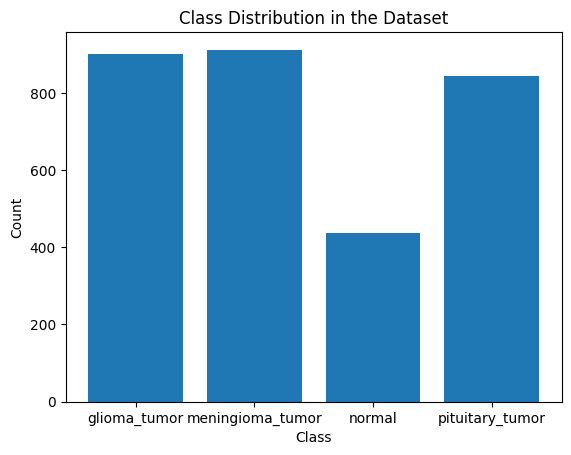

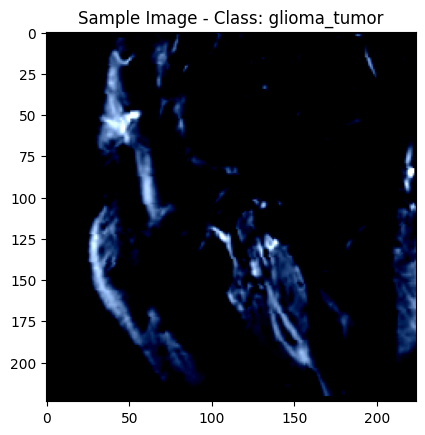

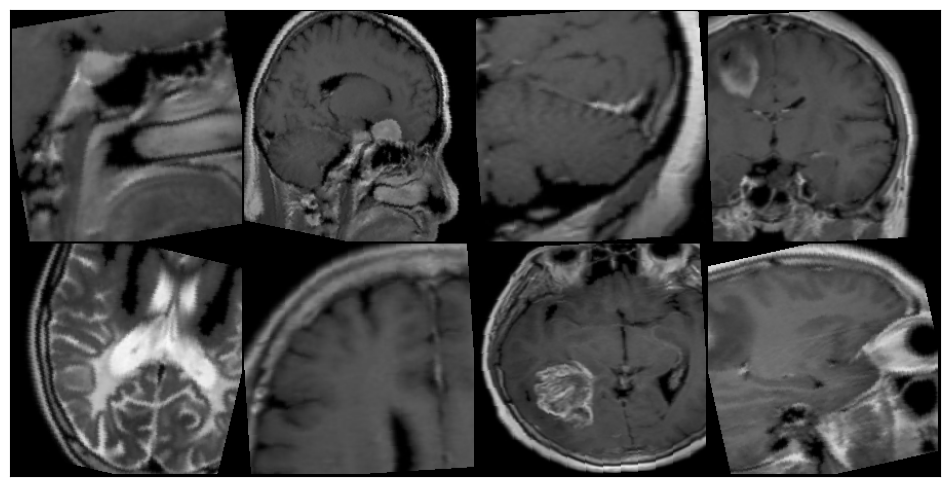

In [3]:
dataset_path = '/content/Data'


transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)
])

# Create a custom dataset
brain_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

batch_size = 32
data_loader = DataLoader(brain_dataset, batch_size=batch_size, shuffle=True)

class_counts = torch.bincount(torch.tensor(brain_dataset.targets))
unique_classes = [brain_dataset.classes[i] for i in range(len(class_counts)) if class_counts[i] > 0]

plt.bar(unique_classes, class_counts[class_counts > 0].numpy())
plt.title('Class Distribution in the Dataset')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Split the data into train and test sets (7:3 ratio)
train_indices, test_indices = train_test_split(list(range(len(brain_dataset))), test_size=0.3, random_state=42)

# Split the data into train and test sets (7:3 ratio)
train_size = int(0.7 * len(brain_dataset))
test_size = len(brain_dataset) - train_size
train_dataset, test_dataset = random_split(brain_dataset, [train_size, test_size])

# Create data loaders for train and test sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Display a sample image
sample_image, sample_label = next(iter(train_loader))
plt.imshow(sample_image[0].permute(1, 2, 0))
plt.title(f'Sample Image - Class: {brain_dataset.classes[sample_label[0]]}')
plt.show()

stats = ([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dltrain_loader):
    for images, labels in train_loader:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(torchvision.utils.make_grid(denorm_images[:8], nrow=4).permute(1, 2, 0).clamp(0,1))
        break

show_batch(train_loader)

*b) Train a ResNet-18 model from scratch using the provided dataset for the classification task. You are free to choose the hyperparameters (batch size, learning rate, optimizer, loss function, etc).*

***Model***

In [4]:
# Load pretrained  ResNet18 model
model = models.resnet18(pretrained=False)

num_classes = len(brain_dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

***Train***

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Define a variable to store the best validation accuracy
best_acc = 0.0

# Lists to store train and test loss and accuracy
train_loss_list = []
train_accuary_list = []
test_loss_list = []
test_accuary_list = []

# Train model
num_epochs = 100

for epoch in range(num_epochs):
    print("Epoch {} running".format(epoch+1))

    # Training
    model.train()
    running_loss = 0.0
    corrects = 0
    total_samples = 0

    with tqdm(train_loader, unit="batch") as tepoch:
        tepoch.set_description(f"Epoch {epoch+1}/{num_epochs}")

        for inputs, labels in tepoch:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)
            total_samples += labels.size(0)

            tepoch.set_postfix(loss=running_loss/total_samples, accuracy=(corrects.double()/total_samples).item())

        scheduler.step()

    # Calculate training accuracy
    epoch_train_acc = corrects.double() / total_samples * 100.0
    epoch_train_loss = running_loss / len(train_loader)

    train_loss_list.append(epoch_train_loss)
    train_accuary_list.append(epoch_train_acc)

    # Validation
    model.eval()
    running_loss = 0.0
    corrects = 0
    total_samples = 0

    with torch.no_grad():
        with tqdm(test_loader, unit="batch") as tepoch:
            tepoch.set_description(f"Validation #{epoch+1}")

            for inputs, labels in tepoch:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                corrects += torch.sum(preds == labels.data)
                total_samples += labels.size(0)

                tepoch.set_postfix(loss=running_loss/total_samples, accuracy=(corrects.double()/total_samples).item())

    # Calculate validation accuracy
    epoch_test_acc = corrects.double() / total_samples * 100.0
    epoch_test_loss = running_loss / len(test_loader)

    test_loss_list.append(epoch_test_loss)
    test_accuary_list.append(epoch_test_acc)

    # Print and save the model with the best test accuracy
    print('[Epoch {}] Training Loss: {:.4f} Acc: {:.4f}% | Validation Loss: {:.4f} Acc: {:.4f}%'.format(
        epoch+1, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc))

    if epoch_test_acc > best_acc:
        best_acc = epoch_test_acc
        torch.save(model.state_dict(), 'best_model.pth')

print('Training complete!')

Epoch 1 running


Validation #1: 100%|██████████| 30/30 [00:04<00:00,  6.62batch/s, accuracy=0.323, loss=0.0703]


[Epoch 1] Training Loss: 1.4466 Acc: 37.0097% | Validation Loss: 2.1761 Acc: 32.2928%
Epoch 2 running


Validation #2: 100%|██████████| 30/30 [00:06<00:00,  4.61batch/s, accuracy=0.508, loss=0.0392]


[Epoch 2] Training Loss: 1.2199 Acc: 47.1620% | Validation Loss: 1.2137 Acc: 50.8073%
Epoch 3 running


Validation #3: 100%|██████████| 30/30 [00:04<00:00,  6.66batch/s, accuracy=0.532, loss=0.0351]


[Epoch 3] Training Loss: 1.1871 Acc: 50.4845% | Validation Loss: 1.0873 Acc: 53.1755%
Epoch 4 running


Validation #4: 100%|██████████| 30/30 [00:05<00:00,  5.49batch/s, accuracy=0.574, loss=0.0388]


[Epoch 4] Training Loss: 1.0583 Acc: 55.2838% | Validation Loss: 1.2023 Acc: 57.3735%
Epoch 5 running


Validation #5: 100%|██████████| 30/30 [00:04<00:00,  6.65batch/s, accuracy=0.587, loss=0.0307]


[Epoch 5] Training Loss: 1.0027 Acc: 57.9603% | Validation Loss: 0.9517 Acc: 58.6652%
Epoch 6 running


Validation #6: 100%|██████████| 30/30 [00:05<00:00,  5.85batch/s, accuracy=0.677, loss=0.025]


[Epoch 6] Training Loss: 0.8610 Acc: 64.0517% | Validation Loss: 0.7747 Acc: 67.7072%
Epoch 7 running


Validation #7: 100%|██████████| 30/30 [00:04<00:00,  6.74batch/s, accuracy=0.714, loss=0.0265]


[Epoch 7] Training Loss: 0.8036 Acc: 65.8053% | Validation Loss: 0.8200 Acc: 71.3671%
Epoch 8 running


Validation #8: 100%|██████████| 30/30 [00:04<00:00,  6.58batch/s, accuracy=0.689, loss=0.0241]


[Epoch 8] Training Loss: 0.7936 Acc: 67.1435% | Validation Loss: 0.7459 Acc: 68.8913%
Epoch 9 running


Validation #9: 100%|██████████| 30/30 [00:04<00:00,  6.11batch/s, accuracy=0.706, loss=0.023]


[Epoch 9] Training Loss: 0.7880 Acc: 67.6511% | Validation Loss: 0.7123 Acc: 70.6136%
Epoch 10 running


Validation #10: 100%|██████████| 30/30 [00:04<00:00,  6.90batch/s, accuracy=0.729, loss=0.0236]


[Epoch 10] Training Loss: 0.7854 Acc: 67.6050% | Validation Loss: 0.7307 Acc: 72.8741%
Epoch 11 running


Validation #11: 100%|██████████| 30/30 [00:05<00:00,  5.42batch/s, accuracy=0.722, loss=0.0231]


[Epoch 11] Training Loss: 0.7290 Acc: 70.3276% | Validation Loss: 0.7152 Acc: 72.2282%
Epoch 12 running


Validation #12: 100%|██████████| 30/30 [00:04<00:00,  6.79batch/s, accuracy=0.727, loss=0.0217]


[Epoch 12] Training Loss: 0.7297 Acc: 70.2353% | Validation Loss: 0.6722 Acc: 72.6588%
Epoch 13 running


Validation #13: 100%|██████████| 30/30 [00:05<00:00,  5.57batch/s, accuracy=0.744, loss=0.0221]


[Epoch 13] Training Loss: 0.7549 Acc: 68.8509% | Validation Loss: 0.6831 Acc: 74.3811%
Epoch 14 running


Validation #14: 100%|██████████| 30/30 [00:04<00:00,  6.81batch/s, accuracy=0.716, loss=0.0223]


[Epoch 14] Training Loss: 0.7312 Acc: 69.6816% | Validation Loss: 0.6899 Acc: 71.5823%
Epoch 15 running


Validation #15: 100%|██████████| 30/30 [00:04<00:00,  6.41batch/s, accuracy=0.73, loss=0.0233]


[Epoch 15] Training Loss: 0.7153 Acc: 71.7582% | Validation Loss: 0.7209 Acc: 72.9817%
Epoch 16 running


Validation #16: 100%|██████████| 30/30 [00:04<00:00,  6.37batch/s, accuracy=0.706, loss=0.0228]


[Epoch 16] Training Loss: 0.7250 Acc: 70.1892% | Validation Loss: 0.7060 Acc: 70.6136%
Epoch 17 running


Validation #17: 100%|██████████| 30/30 [00:04<00:00,  6.87batch/s, accuracy=0.729, loss=0.023]


[Epoch 17] Training Loss: 0.7225 Acc: 71.5275% | Validation Loss: 0.7121 Acc: 72.8741%
Epoch 18 running


Validation #18: 100%|██████████| 30/30 [00:05<00:00,  5.71batch/s, accuracy=0.709, loss=0.0227]


[Epoch 18] Training Loss: 0.7300 Acc: 70.8814% | Validation Loss: 0.7038 Acc: 70.9365%
Epoch 19 running


Validation #19: 100%|██████████| 30/30 [00:04<00:00,  6.92batch/s, accuracy=0.728, loss=0.0226]


[Epoch 19] Training Loss: 0.7343 Acc: 70.5122% | Validation Loss: 0.7003 Acc: 72.7664%
Epoch 20 running


Validation #20: 100%|██████████| 30/30 [00:05<00:00,  5.44batch/s, accuracy=0.707, loss=0.0225]


[Epoch 20] Training Loss: 0.7178 Acc: 71.6659% | Validation Loss: 0.6970 Acc: 70.7212%
Epoch 21 running


Validation #21: 100%|██████████| 30/30 [00:04<00:00,  6.95batch/s, accuracy=0.715, loss=0.0221]


[Epoch 21] Training Loss: 0.7314 Acc: 69.9585% | Validation Loss: 0.6853 Acc: 71.4747%
Epoch 22 running


Validation #22: 100%|██████████| 30/30 [00:05<00:00,  5.65batch/s, accuracy=0.731, loss=0.0214]


[Epoch 22] Training Loss: 0.7150 Acc: 71.1583% | Validation Loss: 0.6627 Acc: 73.0893%
Epoch 23 running


Validation #23: 100%|██████████| 30/30 [00:04<00:00,  6.88batch/s, accuracy=0.738, loss=0.0217]


[Epoch 23] Training Loss: 0.7234 Acc: 70.0508% | Validation Loss: 0.6723 Acc: 73.8428%
Epoch 24 running


Validation #24: 100%|██████████| 30/30 [00:04<00:00,  6.39batch/s, accuracy=0.736, loss=0.0227]


[Epoch 24] Training Loss: 0.7175 Acc: 70.6507% | Validation Loss: 0.7015 Acc: 73.6276%
Epoch 25 running


Validation #25: 100%|██████████| 30/30 [00:04<00:00,  6.32batch/s, accuracy=0.74, loss=0.0222]


[Epoch 25] Training Loss: 0.7285 Acc: 71.5736% | Validation Loss: 0.6866 Acc: 73.9505%
Epoch 26 running


Validation #26: 100%|██████████| 30/30 [00:04<00:00,  6.69batch/s, accuracy=0.72, loss=0.0241]


[Epoch 26] Training Loss: 0.7337 Acc: 71.6659% | Validation Loss: 0.7450 Acc: 72.0129%
Epoch 27 running


Validation #27: 100%|██████████| 30/30 [00:05<00:00,  5.81batch/s, accuracy=0.709, loss=0.0235]


[Epoch 27] Training Loss: 0.7174 Acc: 72.4042% | Validation Loss: 0.7266 Acc: 70.9365%
Epoch 28 running


Validation #28: 100%|██████████| 30/30 [00:04<00:00,  6.89batch/s, accuracy=0.731, loss=0.023]


[Epoch 28] Training Loss: 0.7240 Acc: 70.8353% | Validation Loss: 0.7137 Acc: 73.0893%
Epoch 29 running


Validation #29: 100%|██████████| 30/30 [00:05<00:00,  5.40batch/s, accuracy=0.74, loss=0.0222]


[Epoch 29] Training Loss: 0.7297 Acc: 71.4813% | Validation Loss: 0.6877 Acc: 73.9505%
Epoch 30 running


Validation #30: 100%|██████████| 30/30 [00:04<00:00,  6.64batch/s, accuracy=0.732, loss=0.0224]


[Epoch 30] Training Loss: 0.7225 Acc: 70.8353% | Validation Loss: 0.6932 Acc: 73.1970%
Epoch 31 running


Validation #31: 100%|██████████| 30/30 [00:05<00:00,  5.37batch/s, accuracy=0.719, loss=0.0231]


[Epoch 31] Training Loss: 0.7304 Acc: 71.1121% | Validation Loss: 0.7167 Acc: 71.9053%
Epoch 32 running


Validation #32: 100%|██████████| 30/30 [00:04<00:00,  6.43batch/s, accuracy=0.744, loss=0.0222]


[Epoch 32] Training Loss: 0.7275 Acc: 70.6045% | Validation Loss: 0.6860 Acc: 74.3811%
Epoch 33 running


Validation #33: 100%|██████████| 30/30 [00:05<00:00,  5.59batch/s, accuracy=0.743, loss=0.0216]


[Epoch 33] Training Loss: 0.7241 Acc: 71.6659% | Validation Loss: 0.6692 Acc: 74.2734%
Epoch 34 running


Validation #34: 100%|██████████| 30/30 [00:04<00:00,  6.76batch/s, accuracy=0.743, loss=0.0221]


[Epoch 34] Training Loss: 0.7057 Acc: 71.8043% | Validation Loss: 0.6831 Acc: 74.2734%
Epoch 35 running


Validation #35: 100%|██████████| 30/30 [00:04<00:00,  6.44batch/s, accuracy=0.721, loss=0.0221]


[Epoch 35] Training Loss: 0.7332 Acc: 70.2353% | Validation Loss: 0.6838 Acc: 72.1206%
Epoch 36 running


Validation #36: 100%|██████████| 30/30 [00:04<00:00,  6.11batch/s, accuracy=0.74, loss=0.022]


[Epoch 36] Training Loss: 0.7456 Acc: 69.6816% | Validation Loss: 0.6807 Acc: 73.9505%
Epoch 37 running


Validation #37: 100%|██████████| 30/30 [00:04<00:00,  6.73batch/s, accuracy=0.734, loss=0.022]


[Epoch 37] Training Loss: 0.7350 Acc: 71.3890% | Validation Loss: 0.6804 Acc: 73.4123%
Epoch 38 running


Validation #38: 100%|██████████| 30/30 [00:05<00:00,  5.62batch/s, accuracy=0.744, loss=0.0221]


[Epoch 38] Training Loss: 0.7196 Acc: 71.7582% | Validation Loss: 0.6841 Acc: 74.3811%
Epoch 39 running


Validation #39: 100%|██████████| 30/30 [00:04<00:00,  6.87batch/s, accuracy=0.737, loss=0.0221]


[Epoch 39] Training Loss: 0.7236 Acc: 71.0660% | Validation Loss: 0.6829 Acc: 73.7352%
Epoch 40 running


Validation #40: 100%|██████████| 30/30 [00:05<00:00,  5.46batch/s, accuracy=0.736, loss=0.0219]


[Epoch 40] Training Loss: 0.7026 Acc: 70.9275% | Validation Loss: 0.6780 Acc: 73.6276%
Epoch 41 running


Validation #41: 100%|██████████| 30/30 [00:04<00:00,  6.80batch/s, accuracy=0.716, loss=0.023]


[Epoch 41] Training Loss: 0.7407 Acc: 69.3124% | Validation Loss: 0.7109 Acc: 71.5823%
Epoch 42 running


Validation #42: 100%|██████████| 30/30 [00:05<00:00,  5.47batch/s, accuracy=0.737, loss=0.0224]


[Epoch 42] Training Loss: 0.7319 Acc: 70.5584% | Validation Loss: 0.6926 Acc: 73.7352%
Epoch 43 running


Validation #43: 100%|██████████| 30/30 [00:04<00:00,  6.80batch/s, accuracy=0.747, loss=0.0216]


[Epoch 43] Training Loss: 0.7276 Acc: 70.3276% | Validation Loss: 0.6674 Acc: 74.7040%
Epoch 44 running


Validation #44: 100%|██████████| 30/30 [00:05<00:00,  5.96batch/s, accuracy=0.736, loss=0.0222]


[Epoch 44] Training Loss: 0.7227 Acc: 70.4199% | Validation Loss: 0.6875 Acc: 73.6276%
Epoch 45 running


Validation #45: 100%|██████████| 30/30 [00:04<00:00,  6.67batch/s, accuracy=0.726, loss=0.0222]


[Epoch 45] Training Loss: 0.7372 Acc: 70.2353% | Validation Loss: 0.6868 Acc: 72.5511%
Epoch 46 running


Validation #46: 100%|██████████| 30/30 [00:04<00:00,  6.68batch/s, accuracy=0.733, loss=0.0228]


[Epoch 46] Training Loss: 0.7253 Acc: 70.8353% | Validation Loss: 0.7074 Acc: 73.3046%
Epoch 47 running


Validation #47: 100%|██████████| 30/30 [00:05<00:00,  5.88batch/s, accuracy=0.731, loss=0.0221]


[Epoch 47] Training Loss: 0.7270 Acc: 70.6968% | Validation Loss: 0.6829 Acc: 73.0893%
Epoch 48 running


Validation #48: 100%|██████████| 30/30 [00:04<00:00,  6.69batch/s, accuracy=0.728, loss=0.0221]


[Epoch 48] Training Loss: 0.7270 Acc: 70.8814% | Validation Loss: 0.6837 Acc: 72.7664%
Epoch 49 running


Validation #49: 100%|██████████| 30/30 [00:05<00:00,  5.37batch/s, accuracy=0.733, loss=0.022]


[Epoch 49] Training Loss: 0.7256 Acc: 70.1431% | Validation Loss: 0.6808 Acc: 73.3046%
Epoch 50 running


Validation #50: 100%|██████████| 30/30 [00:04<00:00,  6.73batch/s, accuracy=0.715, loss=0.0228]


[Epoch 50] Training Loss: 0.7304 Acc: 70.8814% | Validation Loss: 0.7053 Acc: 71.4747%
Epoch 51 running


Validation #51: 100%|██████████| 30/30 [00:05<00:00,  5.45batch/s, accuracy=0.722, loss=0.0241]


[Epoch 51] Training Loss: 0.7259 Acc: 70.3738% | Validation Loss: 0.7465 Acc: 72.2282%
Epoch 52 running


Validation #52: 100%|██████████| 30/30 [00:04<00:00,  6.67batch/s, accuracy=0.719, loss=0.0225]


[Epoch 52] Training Loss: 0.7222 Acc: 71.3890% | Validation Loss: 0.6966 Acc: 71.9053%
Epoch 53 running


Validation #53: 100%|██████████| 30/30 [00:05<00:00,  5.59batch/s, accuracy=0.744, loss=0.022]


[Epoch 53] Training Loss: 0.7446 Acc: 69.1740% | Validation Loss: 0.6809 Acc: 74.3811%
Epoch 54 running


Validation #54: 100%|██████████| 30/30 [00:04<00:00,  6.75batch/s, accuracy=0.735, loss=0.0218]


[Epoch 54] Training Loss: 0.7199 Acc: 71.1121% | Validation Loss: 0.6755 Acc: 73.5199%
Epoch 55 running


Validation #55: 100%|██████████| 30/30 [00:05<00:00,  5.98batch/s, accuracy=0.727, loss=0.0233]


[Epoch 55] Training Loss: 0.7286 Acc: 70.8814% | Validation Loss: 0.7213 Acc: 72.6588%
Epoch 56 running


Validation #56: 100%|██████████| 30/30 [00:05<00:00,  5.59batch/s, accuracy=0.718, loss=0.0221]


[Epoch 56] Training Loss: 0.7404 Acc: 70.2353% | Validation Loss: 0.6848 Acc: 71.7976%
Epoch 57 running


Validation #57: 100%|██████████| 30/30 [00:04<00:00,  6.41batch/s, accuracy=0.742, loss=0.0221]


[Epoch 57] Training Loss: 0.7140 Acc: 71.4813% | Validation Loss: 0.6849 Acc: 74.1658%
Epoch 58 running


Validation #58: 100%|██████████| 30/30 [00:04<00:00,  6.21batch/s, accuracy=0.745, loss=0.0212]


[Epoch 58] Training Loss: 0.7337 Acc: 70.4199% | Validation Loss: 0.6552 Acc: 74.4887%
Epoch 59 running


Validation #59: 100%|██████████| 30/30 [00:04<00:00,  6.87batch/s, accuracy=0.715, loss=0.023]


[Epoch 59] Training Loss: 0.7212 Acc: 70.2815% | Validation Loss: 0.7126 Acc: 71.4747%
Epoch 60 running


Validation #60: 100%|██████████| 30/30 [00:05<00:00,  5.69batch/s, accuracy=0.712, loss=0.0229]


[Epoch 60] Training Loss: 0.7368 Acc: 70.6968% | Validation Loss: 0.7099 Acc: 71.1518%
Epoch 61 running


Validation #61: 100%|██████████| 30/30 [00:04<00:00,  6.79batch/s, accuracy=0.732, loss=0.0219]


[Epoch 61] Training Loss: 0.7411 Acc: 70.2815% | Validation Loss: 0.6766 Acc: 73.1970%
Epoch 62 running


Validation #62: 100%|██████████| 30/30 [00:05<00:00,  5.36batch/s, accuracy=0.723, loss=0.0221]


[Epoch 62] Training Loss: 0.7233 Acc: 71.7120% | Validation Loss: 0.6829 Acc: 72.3358%
Epoch 63 running


Validation #63: 100%|██████████| 30/30 [00:04<00:00,  6.69batch/s, accuracy=0.724, loss=0.0224]


[Epoch 63] Training Loss: 0.7015 Acc: 70.9275% | Validation Loss: 0.6923 Acc: 72.4435%
Epoch 64 running


Validation #64: 100%|██████████| 30/30 [00:05<00:00,  5.53batch/s, accuracy=0.715, loss=0.0238]


[Epoch 64] Training Loss: 0.7241 Acc: 70.3276% | Validation Loss: 0.7379 Acc: 71.4747%
Epoch 65 running


Validation #65: 100%|██████████| 30/30 [00:04<00:00,  6.75batch/s, accuracy=0.734, loss=0.0222]


[Epoch 65] Training Loss: 0.7242 Acc: 71.6659% | Validation Loss: 0.6880 Acc: 73.4123%
Epoch 66 running


Validation #66: 100%|██████████| 30/30 [00:04<00:00,  6.05batch/s, accuracy=0.72, loss=0.0225]


[Epoch 66] Training Loss: 0.7311 Acc: 70.5584% | Validation Loss: 0.6978 Acc: 72.0129%
Epoch 67 running


Validation #67: 100%|██████████| 30/30 [00:04<00:00,  6.51batch/s, accuracy=0.747, loss=0.0241]


[Epoch 67] Training Loss: 0.7115 Acc: 70.6507% | Validation Loss: 0.7468 Acc: 74.7040%
Epoch 68 running


Validation #68: 100%|██████████| 30/30 [00:04<00:00,  6.69batch/s, accuracy=0.743, loss=0.0225]


[Epoch 68] Training Loss: 0.7351 Acc: 70.9275% | Validation Loss: 0.6966 Acc: 74.2734%
Epoch 69 running


Validation #69: 100%|██████████| 30/30 [00:05<00:00,  5.81batch/s, accuracy=0.726, loss=0.0221]


[Epoch 69] Training Loss: 0.7647 Acc: 69.3124% | Validation Loss: 0.6844 Acc: 72.5511%
Epoch 70 running


Validation #70: 100%|██████████| 30/30 [00:05<00:00,  5.89batch/s, accuracy=0.744, loss=0.0225]


[Epoch 70] Training Loss: 0.7427 Acc: 69.6816% | Validation Loss: 0.6972 Acc: 74.3811%
Epoch 71 running


Validation #71: 100%|██████████| 30/30 [00:05<00:00,  5.63batch/s, accuracy=0.714, loss=0.0231]


[Epoch 71] Training Loss: 0.7243 Acc: 71.0660% | Validation Loss: 0.7165 Acc: 71.3671%
Epoch 72 running


Validation #72: 100%|██████████| 30/30 [00:04<00:00,  6.67batch/s, accuracy=0.733, loss=0.022]


[Epoch 72] Training Loss: 0.7180 Acc: 71.7582% | Validation Loss: 0.6809 Acc: 73.3046%
Epoch 73 running


Validation #73: 100%|██████████| 30/30 [00:05<00:00,  5.26batch/s, accuracy=0.737, loss=0.022]


[Epoch 73] Training Loss: 0.7259 Acc: 71.2506% | Validation Loss: 0.6821 Acc: 73.7352%
Epoch 74 running


Validation #74: 100%|██████████| 30/30 [00:04<00:00,  6.30batch/s, accuracy=0.732, loss=0.0218]


[Epoch 74] Training Loss: 0.7184 Acc: 70.6968% | Validation Loss: 0.6738 Acc: 73.1970%
Epoch 75 running


Validation #75: 100%|██████████| 30/30 [00:05<00:00,  5.23batch/s, accuracy=0.742, loss=0.0221]


[Epoch 75] Training Loss: 0.7462 Acc: 69.1740% | Validation Loss: 0.6851 Acc: 74.1658%
Epoch 76 running


Validation #76: 100%|██████████| 30/30 [00:04<00:00,  6.60batch/s, accuracy=0.729, loss=0.0221]


[Epoch 76] Training Loss: 0.7258 Acc: 70.7430% | Validation Loss: 0.6831 Acc: 72.8741%
Epoch 77 running


Validation #77: 100%|██████████| 30/30 [00:05<00:00,  5.33batch/s, accuracy=0.722, loss=0.023]


[Epoch 77] Training Loss: 0.7671 Acc: 69.5893% | Validation Loss: 0.7130 Acc: 72.2282%
Epoch 78 running


Validation #78: 100%|██████████| 30/30 [00:04<00:00,  6.35batch/s, accuracy=0.735, loss=0.0218]


[Epoch 78] Training Loss: 0.7543 Acc: 69.1278% | Validation Loss: 0.6751 Acc: 73.5199%
Epoch 79 running


Validation #79: 100%|██████████| 30/30 [00:05<00:00,  5.70batch/s, accuracy=0.749, loss=0.0225]


[Epoch 79] Training Loss: 0.7276 Acc: 70.1431% | Validation Loss: 0.6953 Acc: 74.9193%
Epoch 80 running


Validation #80: 100%|██████████| 30/30 [00:04<00:00,  6.13batch/s, accuracy=0.735, loss=0.0224]


[Epoch 80] Training Loss: 0.7226 Acc: 70.6968% | Validation Loss: 0.6934 Acc: 73.5199%
Epoch 81 running


Validation #81: 100%|██████████| 30/30 [00:05<00:00,  5.70batch/s, accuracy=0.74, loss=0.0218]


[Epoch 81] Training Loss: 0.7221 Acc: 71.4813% | Validation Loss: 0.6747 Acc: 73.9505%
Epoch 82 running


Validation #82: 100%|██████████| 30/30 [00:04<00:00,  6.13batch/s, accuracy=0.716, loss=0.0226]


[Epoch 82] Training Loss: 0.7413 Acc: 70.1431% | Validation Loss: 0.7009 Acc: 71.5823%
Epoch 83 running


Validation #83: 100%|██████████| 30/30 [00:05<00:00,  5.72batch/s, accuracy=0.746, loss=0.022]


[Epoch 83] Training Loss: 0.7176 Acc: 71.9889% | Validation Loss: 0.6809 Acc: 74.5963%
Epoch 84 running


Validation #84: 100%|██████████| 30/30 [00:04<00:00,  6.63batch/s, accuracy=0.735, loss=0.0219]


[Epoch 84] Training Loss: 0.7228 Acc: 70.6045% | Validation Loss: 0.6789 Acc: 73.5199%
Epoch 85 running


Validation #85: 100%|██████████| 30/30 [00:05<00:00,  6.00batch/s, accuracy=0.73, loss=0.0224]


[Epoch 85] Training Loss: 0.7144 Acc: 70.2353% | Validation Loss: 0.6936 Acc: 72.9817%
Epoch 86 running


Validation #86: 100%|██████████| 30/30 [00:05<00:00,  5.91batch/s, accuracy=0.731, loss=0.0225]


[Epoch 86] Training Loss: 0.7272 Acc: 70.6507% | Validation Loss: 0.6979 Acc: 73.0893%
Epoch 87 running


Validation #87: 100%|██████████| 30/30 [00:04<00:00,  6.52batch/s, accuracy=0.727, loss=0.0226]


[Epoch 87] Training Loss: 0.7222 Acc: 71.0198% | Validation Loss: 0.6987 Acc: 72.6588%
Epoch 88 running


Validation #88: 100%|██████████| 30/30 [00:05<00:00,  5.65batch/s, accuracy=0.728, loss=0.0218]


[Epoch 88] Training Loss: 0.7301 Acc: 69.5431% | Validation Loss: 0.6741 Acc: 72.7664%
Epoch 89 running


Validation #89: 100%|██████████| 30/30 [00:04<00:00,  6.38batch/s, accuracy=0.738, loss=0.0217]


[Epoch 89] Training Loss: 0.7507 Acc: 70.5122% | Validation Loss: 0.6722 Acc: 73.8428%
Epoch 90 running


Validation #90: 100%|██████████| 30/30 [00:05<00:00,  5.07batch/s, accuracy=0.716, loss=0.0229]


[Epoch 90] Training Loss: 0.7391 Acc: 70.5584% | Validation Loss: 0.7094 Acc: 71.5823%
Epoch 91 running


Validation #91: 100%|██████████| 30/30 [00:05<00:00,  5.88batch/s, accuracy=0.743, loss=0.0215]


[Epoch 91] Training Loss: 0.7213 Acc: 70.7430% | Validation Loss: 0.6667 Acc: 74.2734%
Epoch 92 running


Validation #92: 100%|██████████| 30/30 [00:05<00:00,  5.34batch/s, accuracy=0.724, loss=0.0215]


[Epoch 92] Training Loss: 0.7496 Acc: 69.0817% | Validation Loss: 0.6650 Acc: 72.4435%
Epoch 93 running


Validation #93: 100%|██████████| 30/30 [00:04<00:00,  6.14batch/s, accuracy=0.741, loss=0.0217]


[Epoch 93] Training Loss: 0.7309 Acc: 70.1431% | Validation Loss: 0.6731 Acc: 74.0581%
Epoch 94 running


Validation #94: 100%|██████████| 30/30 [00:05<00:00,  5.35batch/s, accuracy=0.731, loss=0.0224]


[Epoch 94] Training Loss: 0.7223 Acc: 71.2506% | Validation Loss: 0.6943 Acc: 73.0893%
Epoch 95 running


Validation #95: 100%|██████████| 30/30 [00:04<00:00,  6.75batch/s, accuracy=0.743, loss=0.0228]


[Epoch 95] Training Loss: 0.7246 Acc: 71.1121% | Validation Loss: 0.7074 Acc: 74.2734%
Epoch 96 running


Validation #96: 100%|██████████| 30/30 [00:05<00:00,  5.33batch/s, accuracy=0.728, loss=0.0226]


[Epoch 96] Training Loss: 0.7297 Acc: 70.2815% | Validation Loss: 0.6988 Acc: 72.7664%
Epoch 97 running


Validation #97: 100%|██████████| 30/30 [00:04<00:00,  6.67batch/s, accuracy=0.737, loss=0.0213]


[Epoch 97] Training Loss: 0.7217 Acc: 70.0508% | Validation Loss: 0.6584 Acc: 73.7352%
Epoch 98 running


Validation #98: 100%|██████████| 30/30 [00:05<00:00,  5.31batch/s, accuracy=0.712, loss=0.0222]


[Epoch 98] Training Loss: 0.7348 Acc: 70.2815% | Validation Loss: 0.6887 Acc: 71.1518%
Epoch 99 running


Validation #99: 100%|██████████| 30/30 [00:04<00:00,  6.58batch/s, accuracy=0.723, loss=0.0226]


[Epoch 99] Training Loss: 0.7185 Acc: 71.4813% | Validation Loss: 0.7009 Acc: 72.3358%
Epoch 100 running


Validation #100: 100%|██████████| 30/30 [00:05<00:00,  5.56batch/s, accuracy=0.733, loss=0.0218]

[Epoch 100] Training Loss: 0.7386 Acc: 70.3738% | Validation Loss: 0.6762 Acc: 73.3046%
Training complete!


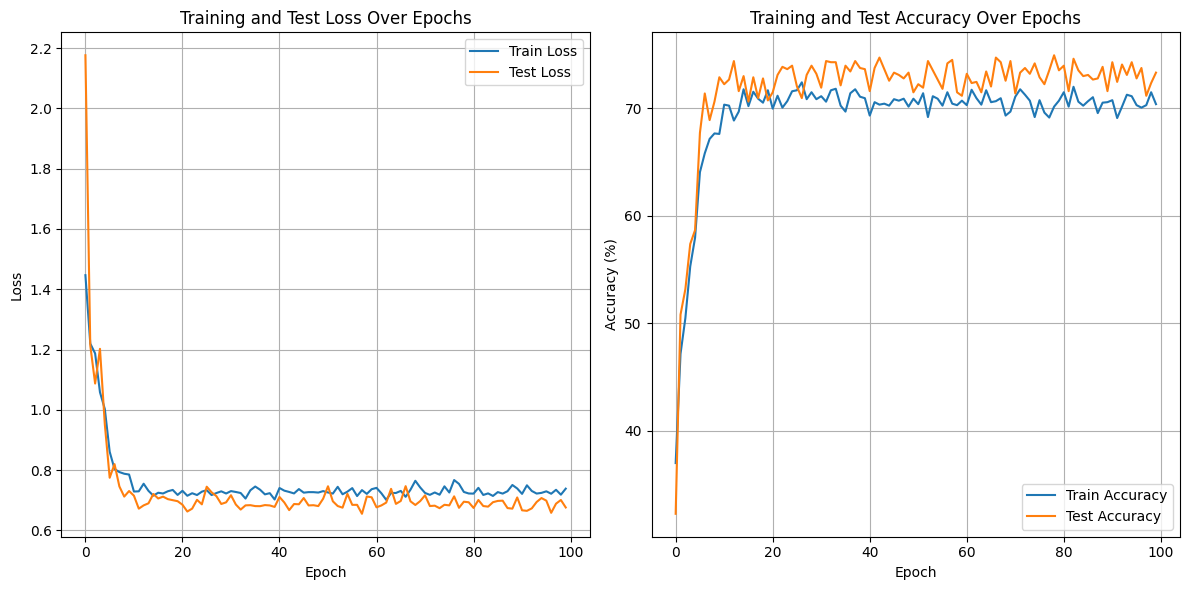

In [8]:
# Plotting

# Convert CUDA tensors to NumPy arrays for plotting
# train_loss_np = [x.cpu().numpy() for x in train_loss_list]
train_accuary_np = [x.cpu().numpy() for x in train_accuary_list]
# test_loss_np = [x.cpu().numpy() for x in test_loss_list]
test_accuary_np = [x.cpu().numpy() for x in test_accuary_list]

plt.figure(figsize=(12, 6))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(test_loss_list, label='Test Loss')
plt.title('Training and Test Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuary_np, label='Train Accuracy')
plt.plot(test_accuary_np, label='Test Accuracy')
plt.title('Training and Test Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()